# Interatomic force field (IFF) optimization for W-based metal alloys

## Calculate configuration statistics for EAM models

Author: Lukas Vlcek

Start Date: 2018-04-22

In [60]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-11-12 20:58:08.373022


In [61]:
%matplotlib inline
import os
import re
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt

# source of raw data and destination for processed data
target_proc = '../data/target_processed'

**Read a list of trajectory datasets for processing**

In [62]:
with open(os.path.join(target_proc,  "datasets_filtered.pickle"), 'rb') as fi:
    datasets = pickle.load(fi)
    print(datasets)

['bcc_npt_langevin_300K_filtered', 'fcc_npt_langevin_300K_filtered', 'vac_npt_langevin_2000K_filtered', 'i110_npt_langevin_2000K_filtered', 'i111_npt_langevin_2000K_filtered', 'screw_111_npt_langevin_2000K_filtered', 'bcc_npt_langevin_3700K_filtered', 'liq_3700K_filtered', 'liq_5000K_filtered']


In [63]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory

In [55]:
###
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

datasets = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

In [56]:
trajdirs = [target_raw + '/' + dataset for dataset in datasets]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]

In [57]:
trajectories = {}
for name, traj_path in zip(datasets[:1], trajdirs[:1]):
    trajectories[name] = read_vasp(traj_path)

Reading ../data/target_raw/bcc_npt_langevin_300K/OUTCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/POSCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/CONTCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/XDATCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/OSZICAR
Reading ../data/target_raw/bcc_npt_langevin_300K/INCAR


In [58]:
# Convert MD trajectory dicts to objects
trjs = {}
for k, trj in trajectories.items():
    trjs[k] = Trajectory(trj, inplace=False)

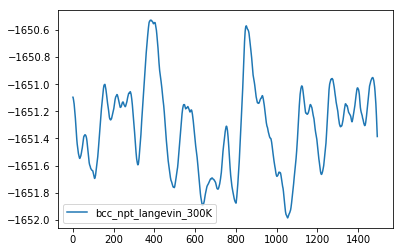

In [59]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    plt.plot(trj['energy'], label=key)

plt.legend()
plt.show()

In [52]:
%load_ext autoreload
%autoreload 2
from statmechlib.preprocessing import pair_dist, get_stats_EAM, get_stats_EAM_pairdist

dataset # bcc_npt_langevin_300K
conf 0
energy -1651.0959
x (1,) [2.88515812] [0.09069371] [0.0001758]
conf 1
energy -1651.0987
x (1,) [2.87613607] [0.09047746] [0.00017682]
conf 2
energy -1651.106


No handles with labels found to put in legend.


x (1,) [2.86484327] [0.09002293] [0.00017638]
conf 3


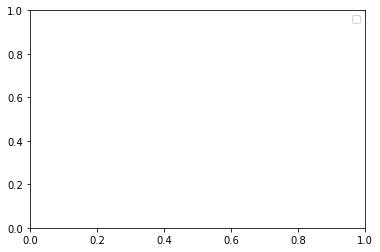

In [54]:
sc = [2.75]

stats_data = {}

for key, trj in trjs.items():
    
    print('dataset #', key)

    # statistics data
    stats_dict = {'energy':[]}
    for ii, (xyz, box) in enumerate(zip(trj['xyz'], trj['box'])):
        print('conf', ii)
        if ii > 2:
            break
            
        print('energy', trj['energy'][ii])
        
        a1, ar, a2, f1, fr, f2 = get_stats_EAM_pairdist(xyz, box, sc=sc)

        #print(xyz.shape, box)
        print('x', a1.shape, ar, a1, a2)

        stats_dict['energy'].append(np.array([ar, a2, a1]))
        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        #if ii == 1:
        #    plt.hist(rr.flatten(),100, alpha=1.0,label=key, histtype='step')
        #    plt.xlim(2,6)
        #    plt.ylim(0,1500)
            
    plt.legend()
    stats_data[key] = stats_dict

In [ ]:
x (1,) [2.88515812] [0.09069371] [0.0001758]
conf 1
x (1,) [2.87613607] [0.09047746] [0.00017682]
conf 2

In [42]:
datasets.append('structs_0k')

In [64]:
datasets

['bcc_npt_langevin_300K_filtered',
 'fcc_npt_langevin_300K_filtered',
 'vac_npt_langevin_2000K_filtered',
 'i110_npt_langevin_2000K_filtered',
 'i111_npt_langevin_2000K_filtered',
 'screw_111_npt_langevin_2000K_filtered',
 'bcc_npt_langevin_3700K_filtered',
 'liq_3700K_filtered',
 'liq_5000K_filtered']

In [65]:
trajectories = []
for dset in datasets:
    with open(os.path.join(target_proc, dset + ".pickle"), 'rb') as fo:
        trajectories.append(pickle.load(fo))

In [66]:
#with open(os.path.join(target_proc, 'structs_0k' + ".pickle"), 'rb') as fo:
#    structs0k = pickle.load(fo)
        #trajectories.append(pickle.load(fo))

In [67]:
#structs0k

Function to calculate atom pair distances in a triclinic box

In [68]:
def pair_dist_triclinic_o(xyz, box):
    """
    Calculates nearest image pair distances between all atoms in xyz array.
    Parameters
    -----------
    xyz : numpy array
          particle x, y, z coordinates
    box : numpy 2D array of unit cell vectors or a float
          simulation box dimensions/shape
    Returns
    -------
    rr  : (natom, natom) numpy array of pair distances
    rx  : (natom, natom, 3) numpy array of pair distance coordinates
    """
    
    # make sure that the box is a 3x3 matrix (if box is float, multiply it by a unit matrix)
    box = np.eye(3).dot(box)

    n_atom = xyz.shape[0] # number of atoms in a configuration
    rr = np.empty((n_atom, n_atom), dtype=float)
    rx = np.empty((n_atom, n_atom, 3), dtype=float)
    
    boxT = box.T
    
    for i, pa in enumerate(xyz):
        for j, pb in enumerate(xyz):
            dp = pa - pb
            dp = np.where(dp < -0.5, dp + 1.0, dp)
            dp = np.where(dp >  0.5, dp - 1.0, dp)
            
            dp = boxT.dot(dp)
            
            rr[i,j] = np.sum(dp*dp)**0.5
            rx[i,j] = dp

    return rr, rx

In [69]:
# sufficient statistics for EAM
def get_stats_EAM_o(rr, rx, sc):
    """
    Takes atom pair distances and calculates sufficeint statistics needed
    for the parameterization of a cubic spline-based EAM model by Bonny et al. (2017).
    
    Parameters
    ----------
    rr : numpy array
         set of pair distances
    rx : numpy array
         set of pair distance coordinates
    sc : python list
         spline nodes
         
    Returns
    -------
    ar, a1, a2 : numpy arrays (len(sc))
                 atom energy-related statistics
                 el_density**0.5, el_density, el_density**2
    br, b1, b2 : numpy arrays (len(sc), natoms, 3 coordinates)
                 atom force-related statistics (gradients of energy)
                 grad(el_density**0.5), grad(el_density), grad(el_density**2)
    """

    n_atom = rr.shape[0]

    # energy-related statistics
    aa = np.empty((n_atom), dtype=float)
    ar = np.zeros((len(sc)), dtype=float)
    a1 = np.zeros_like(ar)
    a2 = np.zeros_like(ar)

    # force-related statistics
    br = np.zeros((len(sc), n_atom, 3), dtype=float)
    b1 = np.zeros_like(br)
    b2 = np.zeros_like(br)
    zero3 = np.zeros((3))

    # cycle over spline nodes
    for ks, rc in enumerate(sc):

        # cycle over atoms
        for i in range(n_atom):

            # sum electronic density over all neighbors of i within rc
            aa[i] = sum([(rc - r)**3 for r in rr[i] if (r < rc and r > 0.01)])

            # if el. density larger than zero, calculate force statistics                                                                                                                                        84,0-1        43%
            if aa[i] > 0.0:

                # precompute a list of recurring values for force statistics
                ff = [1.5*(rc - r)**2*x/r if (r > 0.01 and r < rc) else zero3 for r, x in zip(rr[i], rx[i])]

                # sum contributions to force statistics from all neighbors of i
                b1[ks, i] = sum([2*f       for f in ff])
                br[ks, i] = sum([ -f/np.sqrt(aa[i]) for f in ff])
                b2[ks, i] = sum([4*f*aa[i] for f in ff])

        # sum contributions to energy statistics for a given spline node
        ar[ks] = np.sum(np.sqrt(aa))
        a1[ks] = np.sum(aa)
        a2[ks] = np.sum(aa**2)

    return a1, ar, a2, b1, br, b2

**Calculate pair distances and energy statistics**

Force statistics not calculated for longer MD trajectories.

dataset # <class 'dict'> 5
conf 0
energy -1651.2981
x (6,) [   0.            1.51084109  124.1636447   411.30871972  697.22378245
 1200.30464699] [0.00000000e+00 3.29779109e-02 1.20693813e+02 1.32219335e+03
 3.79853013e+03 1.12567229e+04] [0.00000000e+00 3.17172910e-05 1.14754590e+02 1.36791207e+04
 1.12809763e+05 9.90307760e+05]
conf 1
energy -1651.5014
x (6,) [   0.            1.39672154  124.04475778  411.23781257  697.17738071
 1200.27807671] [0.00000000e+00 2.81749860e-02 1.20464910e+02 1.32174807e+03
 3.79803998e+03 1.12562473e+04] [0.00000000e+00 2.39657787e-05 1.14325957e+02 1.36703215e+04
 1.12782427e+05 9.90231954e+05]
conf 2
energy -1651.5935
x (6,) [   0.            1.30648024  124.01721897  411.26214428  697.22594866
 1200.35206959] [0.00000000e+00 2.47847189e-02 1.20400871e+02 1.32189603e+03
 3.79856401e+03 1.12576343e+04] [0.00000000e+00 1.73976358e-05 1.14163247e+02 1.36729948e+04
 1.12812821e+05 9.90475351e+05]
conf 3
energy -1651.4577
x (6,) [   0.            1.288042

x (6,) [   0.            1.51793488  125.046087    412.89031764  699.15799091
 1202.71052661] [0.00000000e+00 3.08939121e-02 1.22342312e+02 1.33222959e+03
 3.81942921e+03 1.13016025e+04] [0.00000000e+00 2.63267449e-05 1.17632604e+02 1.38812378e+04
 1.14029888e+05 9.98116873e+05]
conf 28
energy -1651.191
x (6,) [   0.            1.45918918  125.12347437  413.03069825  699.33242916
 1202.92655901] [0.00000000e+00 2.92954238e-02 1.22495397e+02 1.33313896e+03
 3.82133900e+03 1.13056677e+04] [0.00000000e+00 2.36727738e-05 1.17930921e+02 1.39003035e+04
 1.14144311e+05 9.98836551e+05]
conf 29
energy -1651.2561
x (6,) [   0.            1.40413029  125.18313008  413.18258009  699.53345675
 1203.18545718] [0.00000000e+00 2.64126585e-02 1.22613183e+02 1.33411332e+03
 3.82352258e+03 1.13105099e+04] [0.00000000e+00 1.70000584e-05 1.18161662e+02 1.39203551e+04
 1.14273109e+05 9.99683359e+05]
conf 30
energy -1651.4079
x (6,) [   0.            1.3921716   125.23005627  413.34617886  699.76247222
 1203

x (6,) [   0.            1.94187491  125.68934327  413.78772767  700.20798435
 1204.00872373] [0.00000000e+00 5.18635476e-02 1.23660319e+02 1.33810123e+03
 3.83099328e+03 1.13261134e+04] [0.00000000e+00 6.96830583e-05 1.20395898e+02 1.40069407e+04
 1.14731306e+05 1.00248597e+06]
conf 55
energy -1650.5737
x (6,) [   0.            1.90731276  125.72217266  413.79700482  700.19130888
 1203.97456341] [0.00000000e+00 5.07981371e-02 1.23730506e+02 1.33817827e+03
 3.83083632e+03 1.13255093e+04] [0.00000000e+00 7.62531261e-05 1.20556389e+02 1.40092980e+04
 1.14725048e+05 1.00239293e+06]
conf 56
energy -1650.5998
x (6,) [   0.            1.81757361  125.69252375  413.77792638  700.17369582
 1203.96046936] [0.00000000e+00 4.41919901e-02 1.23662734e+02 1.33804982e+03
 3.83064406e+03 1.13252540e+04] [0.00000000e+00 5.56259706e-05 1.20387514e+02 1.40064008e+04
 1.14713613e+05 1.00235135e+06]
conf 57
energy -1650.6949
x (6,) [   0.            1.74990635  125.63325414  413.69622598  700.08171447
 120

x (6,) [   0.            1.5521838   126.3381758   415.10519958  701.89690109
 1206.15901106] [0.00000000e+00 3.09401139e-02 1.24932846e+02 1.34670825e+03
 3.84962809e+03 1.13668208e+04] [0.00000000e+00 2.60985806e-05 1.22861015e+02 1.41908316e+04
 1.15866247e+05 1.00978261e+06]
conf 82
energy -1651.0309
x (6,) [   0.            1.67292736  126.51501937  415.33968726  702.16023696
 1206.4796265 ] [0.00000000e+00 3.48316775e-02 1.25301737e+02 1.34825792e+03
 3.85255211e+03 1.13729101e+04] [0.00000000e+00 2.78018857e-05 1.23662183e+02 1.42247106e+04
 1.16046633e+05 1.01088129e+06]
conf 83
energy -1651.0481
x (6,) [   0.            1.64014392  126.55678723  415.42748535  702.27230551
 1206.62912341] [0.00000000e+00 3.29827668e-02 1.25378308e+02 1.34879745e+03
 3.85373426e+03 1.13756552e+04] [0.00000000e+00 2.47119822e-05 1.23791211e+02 1.42348076e+04
 1.16112079e+05 1.01134306e+06]
conf 84
energy -1651.1793
x (6,) [   0.            1.53189634  126.53810408  415.47442061  702.35228058
 120

x (6,) [   0.            1.73396494  126.56154572  415.40330207  702.2481461
 1206.58420749] [0.00000000e+00 3.56521898e-02 1.25325280e+02 1.34853772e+03
 3.85334601e+03 1.13746574e+04] [0.00000000e+00 2.93615954e-05 1.23427628e+02 1.42247858e+04
 1.16073197e+05 1.01110981e+06]
conf 109
energy -1651.0889
x (6,) [   0.            1.82467615  126.66335875  415.50811581  702.35581995
 1206.70473946] [0.00000000e+00 4.21183762e-02 1.25525678e+02 1.34922339e+03
 3.85454027e+03 1.13769524e+04] [0.00000000e+00 4.71995622e-05 1.23819440e+02 1.42394708e+04
 1.16146657e+05 1.01152579e+06]
conf 110
energy -1651.0307
x (6,) [   0.            1.93308974  126.71118661  415.5709771   702.4257923
 1206.78744625] [0.00000000e+00 4.60498891e-02 1.25617639e+02 1.34961596e+03
 3.85528320e+03 1.13784718e+04] [0.00000000e+00 5.67300578e-05 1.23990517e+02 1.42470932e+04
 1.16188394e+05 1.01178163e+06]
conf 111
energy -1651.1396
x (6,) [   0.            1.90593536  126.69171673  415.60840084  702.49362384
 12

x (6,) [3.85134167e-03 3.76621599e+00 1.05367374e+02 3.45644437e+02
 5.81958693e+02 1.00220639e+03] [3.12097097e-06 1.83740266e-01 1.03432606e+02 1.10727590e+03
 3.13707674e+03 9.30138394e+03] [2.44017630e-12 6.98635176e-04 1.01486851e+02 1.13963244e+04
 9.12609054e+04 8.01492807e+05]
conf 16
energy -1357.474
x (6,) [1.59822163e-03 3.67378374e+00 1.05198379e+02 3.45499335e+02
 5.81806962e+02 1.00201654e+03] [6.42319464e-07 1.73760831e-01 1.03100972e+02 1.10636469e+03
 3.13547397e+03 9.29791383e+03] [1.05532730e-13 5.89330669e-04 1.00847078e+02 1.13783974e+04
 9.11716083e+04 8.00913455e+05]
conf 17
energy -1357.589
x (6,) [2.15140267e-02 3.60256546e+00 1.05026461e+02 3.45348470e+02
 5.81652229e+02 1.00182222e+03] [2.31426673e-04 1.70134489e-01 1.02770457e+02 1.10541725e+03
 3.13383662e+03 9.29434939e+03] [2.67791525e-08 6.40412550e-04 1.00226373e+02 1.13596883e+04
 9.10798900e+04 8.00313583e+05]
conf 18
energy -1357.7319
x (6,) [3.26508120e-02 3.59381915e+00 1.04860946e+02 3.45219171e+0

x (6,) [8.64909030e-01 9.76005623e+00 1.31169070e+02 4.09421285e+02
 6.88018586e+02 1.18173323e+03] [4.61669316e-02 1.06484370e+00 1.37000612e+02 1.32267023e+03
 3.73119712e+03 1.10017678e+04] [5.14024301e-04 2.50310613e-02 1.54323582e+02 1.38908063e+04
 1.10075702e+05 9.55054329e+05]
conf 17
energy -1607.0617
x (6,) [6.81166319e-01 9.17429708e+00 1.30900332e+02 4.09380949e+02
 6.88089232e+02 1.18192560e+03] [4.25732634e-02 9.48300585e-01 1.36351934e+02 1.32236498e+03
 3.73196581e+03 1.10054322e+04] [6.29180478e-04 2.23566782e-02 1.52524887e+02 1.38825079e+04
 1.10120760e+05 9.55716185e+05]
conf 18
energy -1607.7418
x (6,) [5.96007268e-01 8.61320403e+00 1.30385349e+02 4.09170552e+02
 6.87986619e+02 1.18193259e+03] [2.80796725e-02 8.44535347e-01 1.35296818e+02 1.32114641e+03
 3.73108341e+03 1.10059530e+04] [2.63582237e-04 1.58505172e-02 1.50239850e+02 1.38623440e+04
 1.10093753e+05 9.55933576e+05]
conf 19
energy -1607.637
x (6,) [5.22297225e-01 8.22472597e+00 1.29937628e+02 4.08936224e+

x (6,) [1.00543550e+00 1.01631876e+01 1.30435261e+02 4.06460375e+02
 6.83709835e+02 1.17609484e+03] [3.94306836e-02 1.11445006e+00 1.35344865e+02 1.30415926e+03
 3.68590595e+03 1.08996028e+04] [1.28924257e-04 2.32768077e-02 1.50209270e+02 1.35270461e+04
 1.07564104e+05 9.38242147e+05]
conf 44
energy -1602.4352
x (6,) [1.14010782e+00 1.05881858e+01 1.30469417e+02 4.06024556e+02
 6.83089038e+02 1.17525286e+03] [6.29387080e-02 1.23304808e+00 1.35482052e+02 1.30139816e+03
 3.67919434e+03 1.08839001e+04] [6.00491174e-04 3.55057215e-02 1.50928342e+02 1.34716508e+04
 1.07171467e+05 9.35510047e+05]
conf 45
energy -1601.4746
x (6,) [   1.20705698   10.80479722  130.61031477  405.86310905  682.71804787
 1174.65369981] [5.94627233e-02 1.27703216e+00 1.35900509e+02 1.30052474e+03
 3.67533975e+03 1.08729087e+04] [4.99040994e-04 3.52705072e-02 1.52445375e+02 1.34609760e+04
 1.06966797e+05 9.33671907e+05]
conf 46
energy -1600.9105
x (6,) [1.13023865e+00 1.07694853e+01 1.30613761e+02 4.05713408e+02
 6

x (6,) [9.79564436e-01 9.34466937e+00 1.29666442e+02 4.06691506e+02
 6.84006122e+02 1.17618524e+03] [4.71502603e-02 1.04336944e+00 1.34075936e+02 1.30540016e+03
 3.68829995e+03 1.08998423e+04] [2.32487651e-04 2.48742685e-02 1.48776820e+02 1.35428599e+04
 1.07614080e+05 9.37811236e+05]
conf 71
energy -1602.0963
x (6,) [9.99322465e-01 9.49471315e+00 1.29894985e+02 4.06954822e+02
 6.84405626e+02 1.17678254e+03] [3.71275292e-02 1.06703980e+00 1.34627232e+02 1.30725388e+03
 3.69280005e+03 1.09111259e+04] [9.67191387e-05 2.38609864e-02 1.50490289e+02 1.35892297e+04
 1.07902141e+05 9.39836124e+05]
conf 72
energy -1602.411
x (6,) [9.54406591e-01 9.63680857e+00 1.30086420e+02 4.07064540e+02
 6.84561181e+02 1.17704842e+03] [3.50414557e-02 1.07791279e+00 1.35048879e+02 1.30809981e+03
 3.69466875e+03 1.09162644e+04] [8.15403269e-05 2.32106760e-02 1.51450992e+02 1.36123012e+04
 1.08033195e+05 9.40793921e+05]
conf 73
energy -1602.804
x (6,) [1.01796291e+00 9.80376057e+00 1.30213803e+02 4.07108445e+0

x (6,) [7.05781609e-01 9.64341168e+00 1.30941666e+02 4.07579133e+02
 6.85036775e+02 1.17754975e+03] [2.24192343e-02 9.38235919e-01 1.36062536e+02 1.31022349e+03
 3.69856844e+03 1.09242775e+04] [4.53888852e-05 1.41858323e-02 1.50189785e+02 1.36077487e+04
 1.08119002e+05 9.41738798e+05]
conf 98
energy -1604.4804
x (6,) [6.32826565e-01 9.43406800e+00 1.30769982e+02 4.07399649e+02
 6.84889914e+02 1.17743654e+03] [1.91229274e-02 9.23367579e-01 1.35802676e+02 1.30925243e+03
 3.69726590e+03 1.09226666e+04] [4.11993511e-05 1.43017362e-02 1.50044037e+02 1.35947757e+04
 1.08074287e+05 9.41621945e+05]
conf 99
energy -1604.8368
x (6,) [5.86154696e-01 9.13553105e+00 1.30549737e+02 4.07308994e+02
 6.84869733e+02 1.17747774e+03] [1.53937621e-02 8.79940638e-01 1.35518697e+02 1.30904858e+03
 3.69756628e+03 1.09241907e+04] [1.83398231e-05 1.30065695e-02 1.50136712e+02 1.36057246e+04
 1.08150258e+05 9.42136679e+05]
conf 100
energy -1605.2136
x (6,) [6.15611326e-01 9.10346098e+00 1.30106986e+02 4.06931766

x (6,) [9.22992030e-01 8.95337342e+00 1.28225587e+02 4.05293191e+02
 6.84863557e+02 1.18303765e+03] [5.37749782e-02 1.02724326e+00 1.29745528e+02 1.27692729e+03
 3.64014776e+03 1.08547001e+04] [4.99536697e-04 3.50029400e-02 1.40583743e+02 1.27817790e+04
 1.03188535e+05 9.15130569e+05]
conf 7
energy -1625.1475
x (6,) [8.23840042e-01 8.74527648e+00 1.27662157e+02 4.04416938e+02
 6.83819026e+02 1.18174864e+03] [4.19135869e-02 9.67733005e-01 1.28576891e+02 1.27138544e+03
 3.62906700e+03 1.08311467e+04] [2.00102494e-04 2.91073130e-02 1.37746728e+02 1.26691878e+04
 1.02561293e+05 9.11188925e+05]
conf 8
energy -1624.7174
x (6,) [8.53001478e-01 8.87781388e+00 1.27352774e+02 4.03785635e+02
 6.82976690e+02 1.18063115e+03] [4.62787114e-02 9.94473017e-01 1.27939330e+02 1.26742383e+03
 3.62020605e+03 1.08108622e+04] [2.19528547e-04 2.99771677e-02 1.36217773e+02 1.25900975e+04
 1.02068030e+05 9.07837505e+05]
conf 9
energy -1623.4777
x (6,) [1.13537658e+00 9.46609528e+00 1.27337014e+02 4.03456259e+02

x (6,) [   1.21293539    9.16494904  126.17418646  401.33397333  679.56439678
 1176.3581453 ] [7.61029792e-02 1.17233925e+00 1.26294954e+02 1.25340211e+03
 3.58572115e+03 1.07348031e+04] [8.20248693e-04 4.36027172e-02 1.36169767e+02 1.23693261e+04
 1.00321730e+05 8.95818231e+05]
conf 34
energy -1619.7427
x (6,) [   1.30288291    9.39453779  126.52319006  401.59520915  679.71125009
 1176.40269081] [8.11237132e-02 1.24914447e+00 1.27160307e+02 1.25502958e+03
 3.58716149e+03 1.07354125e+04] [7.03803123e-04 4.81575914e-02 1.38473540e+02 1.23988632e+04
 1.00384713e+05 8.95839735e+05]
conf 35
energy -1619.8143
x (6,) [1.13022378e+00 9.31859753e+00 1.26440912e+02 4.01481235e+02
 6.79577406e+02 1.17623453e+03] [6.32618840e-02 1.18687081e+00 1.26931614e+02 1.25406277e+03
 3.58537770e+03 1.07318294e+04] [3.71867574e-04 4.20866153e-02 1.37449747e+02 1.23672596e+04
 1.00237177e+05 8.95054029e+05]
conf 36
energy -1619.9959
x (6,) [8.90037377e-01 9.12901400e+00 1.26480041e+02 4.01452412e+02
 6.79555

x (6,) [   1.75362072   11.64801332  131.67133036  407.82146771  686.8379592
 1184.67782416] [9.52556141e-02 1.60438905e+00 1.36919484e+02 1.29315961e+03
 3.66161701e+03 1.08857035e+04] [6.86708689e-04 5.96342515e-02 1.57401721e+02 1.31214550e+04
 1.04464390e+05 9.20668214e+05]
conf 61
energy -1619.5019
x (6,) [   1.67546375   11.77519886  131.60007982  407.94161944  687.10486022
 1185.13923342] [9.81061125e-02 1.57178157e+00 1.36545637e+02 1.29379293e+03
 3.66446696e+03 1.08943060e+04] [8.43661248e-04 5.46051169e-02 1.55417844e+02 1.31284135e+04
 1.04625860e+05 9.22160503e+05]
conf 62
energy -1620.7382
x (6,) [   1.54350354   11.60466774  131.24028341  407.86425764  687.2270167
 1185.49643496] [1.02076596e-01 1.49199844e+00 1.35620091e+02 1.29328447e+03
 3.66588889e+03 1.09011149e+04] [1.38605769e-03 5.44703114e-02 1.52593962e+02 1.31170279e+04
 1.04718676e+05 9.23388241e+05]
conf 63
energy -1621.6328
x (6,) [   1.31422405   11.11383654  130.8359501   407.83772032  687.41267787
 1185.

x (6,) [   1.40647461   10.41714032  131.53658224  409.47326663  689.43535896
 1188.52076908] [1.45487169e-01 1.45155261e+00 1.36543334e+02 1.30366413e+03
 3.68960372e+03 1.09569825e+04] [5.55656225e-03 9.40825944e-02 1.56535167e+02 1.33363956e+04
 1.06096522e+05 9.32954537e+05]
conf 88
energy -1621.2778
x (6,) [   1.23401177   10.20865403  131.3681911   409.47649465  689.43755834
 1188.47351066] [8.95435355e-02 1.33119754e+00 1.36140623e+02 1.30367033e+03
 3.68963856e+03 1.09561664e+04] [1.43147100e-03 6.17095563e-02 1.55152088e+02 1.33363731e+04
 1.06102686e+05 9.32843236e+05]
conf 89
energy -1621.8049
x (6,) [1.05397337e+00 9.91509669e+00 1.30909340e+02 4.09290206e+02
 6.89329576e+02 1.18836720e+03] [8.53470563e-02 1.25258690e+00 1.35249468e+02 1.30254075e+03
 3.68847536e+03 1.09541160e+04] [1.90730395e-03 6.09050879e-02 1.53501090e+02 1.33166385e+04
 1.06037617e+05 9.32469032e+05]
conf 90
energy -1621.7911
x (6,) [   1.29350875    9.88026183  130.56086306  409.07865405  689.1538190

x (6,) [   1.19776646   10.30610922  130.93149342  409.09968084  689.49013347
 1188.89924422] [6.77896269e-02 1.28559119e+00 1.35175054e+02 1.30078763e+03
 3.68922847e+03 1.09622557e+04] [5.15821089e-04 4.69927181e-02 1.52633789e+02 1.32584663e+04
 1.05966981e+05 9.33276842e+05]
conf 115
energy -1623.8873
x (6,) [   1.35571195   10.38139863  131.30297786  409.63729973  690.13676928
 1189.69878054] [8.83365420e-02 1.37408524e+00 1.36083605e+02 1.30445033e+03
 3.69649511e+03 1.09775085e+04] [7.81962040e-04 5.72876374e-02 1.55567809e+02 1.33441177e+04
 1.06425336e+05 9.36047661e+05]
conf 116
energy -1624.2151
x (6,) [   1.43942442   10.51070794  131.29466541  409.8841344   690.60207009
 1190.42648902] [1.13007244e-01 1.43498916e+00 1.36244310e+02 1.30638896e+03
 3.70196029e+03 1.09915915e+04] [1.50050196e-03 7.38892675e-02 1.57266174e+02 1.34006460e+04
 1.06797455e+05 9.38673806e+05]
dataset # <class 'dict'> 5
conf 0
energy -1627.2573
x (6,) [   1.81245207   10.70493917  132.60497469  413

x (6,) [1.03031313e+00 9.00507128e+00 1.27601228e+02 4.03855685e+02
 6.83002560e+02 1.18081366e+03] [1.18975463e-01 1.17615438e+00 1.29136252e+02 1.26925871e+03
 3.62229778e+03 1.08167181e+04] [4.11505345e-03 8.86330459e-02 1.43823402e+02 1.26889148e+04
 1.02398806e+05 9.09671806e+05]
conf 25
energy -1623.3518
x (6,) [9.35309079e-01 8.77437494e+00 1.27537024e+02 4.03904906e+02
 6.83071662e+02 1.18090682e+03] [9.76633000e-02 1.10602817e+00 1.29061331e+02 1.26975890e+03
 3.62333703e+03 1.08189383e+04] [3.05964389e-03 7.25718579e-02 1.43389218e+02 1.27051387e+04
 1.02492181e+05 9.10225687e+05]
conf 26
energy -1623.1891
x (6,) [9.16620431e-01 8.75530359e+00 1.27722054e+02 4.04123114e+02
 6.83280682e+02 1.18109644e+03] [7.13976060e-02 1.04836929e+00 1.29352470e+02 1.27106403e+03
 3.62554047e+03 1.08225157e+04] [1.23221306e-03 4.79936746e-02 1.42798291e+02 1.27265225e+04
 1.02615622e+05 9.10873773e+05]
conf 27
energy -1622.7619
x (6,) [9.43810213e-01 9.16585843e+00 1.28215292e+02 4.04448358e

x (6,) [1.06913597e+00 9.83639991e+00 1.29572970e+02 4.06328317e+02
 6.86094305e+02 1.18473302e+03] [4.68024317e-02 1.17514534e+00 1.32518885e+02 1.28382473e+03
 3.65389819e+03 1.08868357e+04] [1.51192988e-04 3.20879376e-02 1.46476541e+02 1.29350397e+04
 1.04044444e+05 9.20894124e+05]
conf 52
energy -1622.9723
x (6,) [   1.22641245   10.77652142  130.6031628   407.20256547  686.82930892
 1185.41447421] [5.59226014e-02 1.34065762e+00 1.34652308e+02 1.28931260e+03
 3.66166612e+03 1.08992477e+04] [2.62838793e-04 3.70300605e-02 1.51276386e+02 1.30452094e+04
 1.04482516e+05 9.22961076e+05]
conf 53
energy -1621.2252
x (6,) [   1.4274795    11.30499954  131.22689797  407.82296974  687.35039968
 1185.88317893] [6.61791163e-02 1.45910811e+00 1.36003144e+02 1.29331005e+03
 3.66731214e+03 1.09079962e+04] [4.53373569e-04 4.25721170e-02 1.54633700e+02 1.31291426e+04
 1.04815239e+05 9.24485603e+05]
conf 54
energy -1620.1841
x (6,) [   1.648182     11.43134214  131.50591166  408.08535314  687.5453660

x (6,) [   1.55118304   10.8094493   131.54515301  410.25503454  690.79485147
 1190.560895  ] [1.44034466e-01 1.56019605e+00 1.37276258e+02 1.30968716e+03
 3.70506507e+03 1.09951978e+04] [3.47831284e-03 9.69921956e-02 1.61878178e+02 1.35069813e+04
 1.07096263e+05 9.39666027e+05]
conf 79
energy -1620.7778
x (6,) [   1.82504203   11.2035693   131.58320475  410.26451412  690.82232999
 1190.58845973] [1.84891199e-01 1.76987012e+00 1.37655253e+02 1.30978444e+03
 3.70520629e+03 1.09953412e+04] [4.59463842e-03 1.23178281e-01 1.64461500e+02 1.35123606e+04
 1.07089699e+05 9.39569667e+05]
conf 80
energy -1621.3183
x (6,) [   2.0686037    11.30882607  131.39090491  410.08032288  690.71733642
 1190.51474015] [2.21894427e-01 1.89283642e+00 1.37427595e+02 1.30858800e+03
 3.70392688e+03 1.09936819e+04] [5.98074899e-03 1.45679962e-01 1.65172231e+02 1.34889343e+04
 1.07001213e+05 9.39188871e+05]
conf 81
energy -1622.5015
x (6,) [   2.03291664   11.10847831  131.17454913  409.76858136  690.41909194
 119

x (6,) [   1.4741034    11.05933556  132.95635286  412.90465565  694.67151225
 1195.8689565 ] [1.37884400e-01 1.52884106e+00 1.39461669e+02 1.32535932e+03
 3.74519349e+03 1.10916769e+04] [3.58171103e-03 9.98158162e-02 1.64228815e+02 1.37812242e+04
 1.09251300e+05 9.55632395e+05]
conf 106
energy -1626.1347
x (6,) [   1.54887691   10.88552317  132.87720291  413.1966477   695.15585072
 1196.56173611] [1.42275836e-01 1.54467452e+00 1.39399466e+02 1.32717181e+03
 3.75022080e+03 1.11041286e+04] [3.78059509e-03 1.05263718e-01 1.64788231e+02 1.38180197e+04
 1.09525099e+05 9.57646961e+05]
conf 107
energy -1626.1286
x (6,) [   1.48613537   10.59245277  132.804511    413.41465638  695.50317543
 1197.06495704] [1.44572967e-01 1.52379765e+00 1.39379991e+02 1.32861918e+03
 3.75392632e+03 1.11132549e+04] [4.58997260e-03 1.11514918e-01 1.65518456e+02 1.38508274e+04
 1.09737068e+05 9.59144765e+05]
conf 108
energy -1626.4564
x (6,) [   1.28237683   10.24945864  132.63453489  413.57203288  695.8063784
 1

x (6,) [6.11969326e-01 8.20570911e+00 1.17341224e+02 3.46366830e+02
 5.60432011e+02 9.27809511e+02] [2.42415025e-02 7.77740957e-01 1.03831195e+02 8.92419778e+02
 2.33180032e+03 6.38407023e+03] [6.80845654e-05 1.30213738e-02 8.53831498e+01 5.99701222e+03
 4.06343594e+04 3.03312152e+05]
conf 15
energy -1704.3847
x (6,) [6.46746527e-01 8.34484282e+00 1.17400109e+02 3.46257325e+02
 5.60264294e+02 9.27578922e+02] [3.47326698e-02 8.15730255e-01 1.03866735e+02 8.91628358e+02
 2.33004510e+03 6.38034948e+03] [1.87975310e-04 1.64419306e-02 8.52904710e+01 5.98075407e+03
 4.05495204e+04 3.02858884e+05]
conf 16
energy -1704.986
x (6,) [5.45218155e-01 8.39653495e+00 1.17274400e+02 3.45913499e+02
 5.59829551e+02 9.27020878e+02] [2.59371912e-02 7.79423513e-01 1.03422922e+02 8.89476436e+02
 2.32591838e+03 6.37196990e+03] [1.14176912e-04 1.29379703e-02 8.39098258e+01 5.94268645e+03
 4.03733328e+04 3.01939085e+05]
conf 17
energy -1705.8089
x (6,) [4.47309843e-01 8.52431065e+00 1.16994380e+02 3.45579501e+

x (6,) [4.09388142e-01 7.55984734e+00 1.12807868e+02 3.37853410e+02
 5.49831066e+02 9.14374432e+02] [1.14539723e-02 6.24342346e-01 9.57226337e+01 8.48831030e+02
 2.24413198e+03 6.20010366e+03] [1.91761147e-05 7.84717466e-03 7.19443573e+01 5.41991446e+03
 3.76202060e+04 2.86016781e+05]
conf 42
energy -1702.4989
x (6,) [5.56861287e-01 7.47980481e+00 1.12256547e+02 3.37451986e+02
 5.49499188e+02 9.14059779e+02] [1.51940272e-02 6.75457667e-01 9.50249849e+01 8.46988291e+02
 2.24153679e+03 6.19585847e+03] [2.23587258e-05 9.77728595e-03 7.15597698e+01 5.40106065e+03
 3.75419316e+04 2.85633242e+05]
conf 43
energy -1703.1836
x (6,) [6.63220402e-01 7.33544947e+00 1.11771634e+02 3.37117552e+02
 5.49224461e+02 9.13810358e+02] [2.63360406e-02 7.06202217e-01 9.44045971e+01 8.45529289e+02
 2.23952008e+03 6.19271700e+03] [7.26965575e-05 1.31101630e-02 7.12618059e+01 5.38837669e+03
 3.74903295e+04 2.85390275e+05]
conf 44
energy -1704.2191
x (6,) [6.70313576e-01 6.84805599e+00 1.11142468e+02 3.36731986e

x (6,) [3.99098248e-01 6.18493743e+00 1.08846856e+02 3.32384945e+02
 5.43406202e+02 9.06580489e+02] [1.54388735e-02 5.03451629e-01 8.94120527e+01 8.21955785e+02
 2.19243807e+03 6.09542854e+03] [3.68414006e-05 7.46964203e-03 6.37493695e+01 5.09284623e+03
 3.59394176e+04 2.76552089e+05]
conf 69
energy -1704.2105
x (6,) [4.33477861e-01 6.09086020e+00 1.08763817e+02 3.32203745e+02
 5.43166304e+02 9.06287638e+02] [1.52083374e-02 4.90926768e-01 8.90979983e+01 8.20675000e+02
 2.18999765e+03 6.09079898e+03] [4.01356552e-05 7.16531473e-03 6.26954716e+01 5.06673296e+03
 3.58244644e+04 2.76001246e+05]
conf 70
energy -1703.7303
x (6,) [4.91451208e-01 6.41575197e+00 1.09083339e+02 3.32376669e+02
 5.43293902e+02 9.06421283e+02] [1.45883171e-02 5.38381021e-01 8.96069417e+01 8.21554893e+02
 2.19108979e+03 6.09269917e+03] [2.24071276e-05 7.27182066e-03 6.32741283e+01 5.07739759e+03
 3.58621081e+04 2.76186171e+05]
conf 71
energy -1702.2737
x (6,) [5.94184221e-01 6.97792633e+00 1.09306108e+02 3.32066974e

x (6,) [6.47954135e-01 7.17926218e+00 1.07928176e+02 3.28904500e+02
 5.38604042e+02 9.00320984e+02] [2.55617647e-02 6.95250628e-01 8.83055614e+01 8.05217827e+02
 2.15424008e+03 6.01190423e+03] [6.11630689e-05 1.20760207e-02 6.30181056e+01 4.89571950e+03
 3.47201623e+04 2.69083649e+05]
conf 96
energy -1699.468
x (6,) [6.48760307e-01 6.93373055e+00 1.07550542e+02 3.28700394e+02
 5.38525361e+02 9.00336072e+02] [2.88140407e-02 6.75567654e-01 8.76720244e+01 8.04217426e+02
 2.15359616e+03 6.01205815e+03] [1.01638092e-04 1.28946443e-02 6.21624311e+01 4.88336212e+03
 3.46974792e+04 2.69085822e+05]
conf 97
energy -1700.4348
x (6,) [5.79138204e-01 6.57057935e+00 1.07004891e+02 3.28440780e+02
 5.38432848e+02 9.00379771e+02] [2.11152070e-02 6.08299513e-01 8.67539959e+01 8.02969940e+02
 2.15290834e+03 6.01272362e+03] [5.96061176e-05 1.00260703e-02 6.07836021e+01 4.86856716e+03
 3.46780604e+04 2.69158463e+05]
conf 98
energy -1701.3651
x (6,) [4.16949676e-01 6.09840684e+00 1.06266951e+02 3.27971064e+

x (6,) [3.76368852e-01 6.30465591e+00 1.05751168e+02 3.26534145e+02
 5.36179210e+02 8.97631482e+02] [8.94995651e-03 5.29895417e-01 8.46147420e+01 7.93797562e+02
 2.13532064e+03 5.97697168e+03] [8.33994372e-06 6.12153680e-03 5.76172947e+01 4.76235205e+03
 3.41422718e+04 2.66133060e+05]
conf 123
energy -1697.9093
x (6,) [5.28857741e-01 6.68016502e+00 1.06299509e+02 3.26759531e+02
 5.36245849e+02 8.97561040e+02] [1.58378212e-02 6.02999782e-01 8.55341570e+01 7.94837394e+02
 2.13569944e+03 5.97571011e+03] [2.74211931e-05 8.81279010e-03 5.90071189e+01 4.77325435e+03
 3.41438082e+04 2.65960382e+05]
conf 124
energy -1697.2203
x (6,) [6.09334509e-01 6.87405520e+00 1.06490923e+02 3.26716619e+02
 5.36112620e+02 8.97362730e+02] [1.89632053e-02 6.36640000e-01 8.58563581e+01 7.94642626e+02
 2.13463641e+03 5.97302090e+03] [2.79540386e-05 9.55014487e-03 5.94516837e+01 4.77099526e+03
 3.41091862e+04 2.65711534e+05]
conf 125
energy -1697.5243
x (6,) [6.36177876e-01 6.96886282e+00 1.06442510e+02 3.266283

x (6,) [2.77989314e-01 5.70698410e+00 1.06678788e+02 3.29691216e+02
 5.40540494e+02 9.03357685e+02] [7.17229214e-03 4.32533465e-01 8.57878790e+01 8.08418936e+02
 2.16893209e+03 6.05147647e+03] [1.16373451e-05 4.49650366e-03 5.81885479e+01 4.91778242e+03
 3.51386041e+04 2.72438324e+05]
conf 150
energy -1700.8159
x (6,) [3.08914145e-01 6.16591673e+00 1.07156996e+02 3.29920680e+02
 5.40629361e+02 9.03342112e+02] [7.48616022e-03 4.81077745e-01 8.64776936e+01 8.09433970e+02
 2.16952746e+03 6.05115432e+03] [7.89903044e-06 4.88000850e-03 5.89223595e+01 4.92749925e+03
 3.51503808e+04 2.72389337e+05]
conf 151
energy -1700.0529
x (6,) [4.01382615e-01 6.45550189e+00 1.07680638e+02 3.30474741e+02
 5.41175931e+02 9.03931128e+02] [1.47615890e-02 5.26267360e-01 8.73341182e+01 8.12122547e+02
 2.17387350e+03 6.05900801e+03] [4.57890011e-05 7.12419825e-03 6.02114234e+01 4.96023758e+03
 3.52902957e+04 2.73094082e+05]
conf 152
energy -1699.8038
x (6,) [4.36274605e-01 6.66310135e+00 1.08225204e+02 3.310341

x (6,) [   2.34434959   14.43652964  136.32256895  407.55293028  682.1169583
 1173.95850764] [1.34294861e-01 2.19704305e+00 1.48111134e+02 1.30364572e+03
 3.64366050e+03 1.07798319e+04] [1.37915208e-03 7.92318373e-02 1.84784428e+02 1.35241668e+04
 1.04715659e+05 9.12211367e+05]
conf 7
energy -1589.8757
x (6,) [   2.31780239   14.18924556  135.66984085  406.77352003  681.16367636
 1172.68687692] [1.28021068e-01 2.12855099e+00 1.46605080e+02 1.29835711e+03
 3.63310358e+03 1.07559915e+04] [1.06591498e-03 7.40975310e-02 1.80787320e+02 1.34029775e+04
 1.04066603e+05 9.08005628e+05]
conf 8
energy -1590.9076
x (6,) [   2.38669797   14.28120051  135.04993064  406.01371748  680.25683979
 1171.51965746] [1.30562965e-01 2.13329364e+00 1.45089427e+02 1.29301034e+03
 3.62272670e+03 1.07335405e+04] [6.73656654e-04 7.16352744e-02 1.76415499e+02 1.32728592e+04
 1.03391107e+05 9.03853714e+05]
conf 9
energy -1591.0693
x (6,) [   2.58085917   14.57648221  134.9295207   405.49127628  679.51653019
 1170.46

x (6,) [   2.97062213   14.0325003   128.47446217  389.20106419  656.42314207
 1138.82113877] [3.31393743e-01 2.44757288e+00 1.32249112e+02 1.18916076e+03
 3.37399144e+03 1.01430242e+04] [1.01100058e-02 1.66238904e-01 1.50804956e+02 1.12608725e+04
 8.97433756e+04 8.07218527e+05]
conf 34
energy -1577.3162
x (6,) [   2.94078257   14.33155303  128.15666093  388.56244869  655.72847894
 1138.08818965] [3.14810735e-01 2.44191757e+00 1.31415768e+02 1.18495867e+03
 3.36655049e+03 1.01296530e+04] [8.71467583e-03 1.57748799e-01 1.48013559e+02 1.11692444e+04
 8.93136725e+04 8.04983711e+05]
conf 35
energy -1577.9835
x (6,) [   2.85615677   14.33547987  127.76624614  388.10443604  655.21470114
 1137.51061524] [2.15948701e-01 2.28001295e+00 1.30485728e+02 1.18218416e+03
 3.36143838e+03 1.01196635e+04] [2.57773114e-03 1.02111151e-01 1.44861440e+02 1.11164571e+04
 8.90576765e+04 8.03484377e+05]
conf 36
energy -1579.5123
x (6,) [   2.3383742    13.42596525  126.87914986  387.41529207  654.57444282
 113

x (6,) [   2.64356101   13.80917753  125.52383588  383.42043241  648.32790017
 1127.45747986] [1.78016578e-01 2.10957918e+00 1.26121818e+02 1.15500765e+03
 3.29365185e+03 9.94631119e+03] [1.68539934e-03 8.22292796e-02 1.35526322e+02 1.06522598e+04
 8.57516049e+04 7.77621539e+05]
conf 61
energy -1571.3973
x (6,) [   3.09057541   14.34736851  126.1442564   383.92383145  648.68872654
 1127.64766358] [2.24830929e-01 2.36449863e+00 1.27610970e+02 1.15862137e+03
 3.29818366e+03 9.95102141e+03] [2.04889590e-03 1.05692274e-01 1.40045576e+02 1.07418420e+04
 8.60814956e+04 7.78792950e+05]
conf 62
energy -1570.0899
x (6,) [   3.24262292   14.60365989  126.5995018   384.3075461   649.0148322
 1127.91599791] [2.93408536e-01 2.55154437e+00 1.28705659e+02 1.16121257e+03
 3.30178507e+03 9.95607232e+03] [4.57981555e-03 1.44587495e-01 1.44053288e+02 1.08044530e+04
 8.63068552e+04 7.79694229e+05]
conf 63
energy -1570.0955
x (6,) [   3.12295332   14.36888256  126.23827671  383.87890474  648.56007317
 1127

x (6,) [   3.23431313   15.19228086  132.27198198  393.95045557  660.44690601
 1142.10714721] [2.02578291e-01 2.50977166e+00 1.40024189e+02 1.21968506e+03
 3.41892424e+03 1.02089618e+04] [1.19852604e-03 9.63909803e-02 1.66765362e+02 1.18835491e+04
 9.24753118e+04 8.19932816e+05]
conf 88
energy -1570.0289
x (6,) [   3.34698324   15.44707446  132.72539066  394.67029096  661.39763969
 1143.35134027] [2.18152515e-01 2.54156255e+00 1.40757794e+02 1.22375026e+03
 3.42830687e+03 1.02305681e+04] [1.63173206e-03 9.95406912e-02 1.67806081e+02 1.19480963e+04
 9.29325513e+04 8.23194524e+05]
conf 89
energy -1570.5806
x (6,) [   3.24177505   15.57949761  133.21071374  395.4847578   662.47913951
 1144.7133325 ] [2.12193060e-01 2.54156708e+00 1.41614800e+02 1.22841848e+03
 3.43892955e+03 1.02539238e+04] [1.87165334e-03 1.00041661e-01 1.69196327e+02 1.20264987e+04
 9.34512753e+04 8.26646353e+05]
conf 90
energy -1571.2094
x (6,) [   3.14324484   15.76975227  133.55383832  396.25248275  663.59239932
 114

x (6,) [  5.1337364   17.33381959 111.59961639 307.22703939 506.71221888
 876.30347115] [6.17850523e-01 3.82472436e+00 1.14967521e+02 8.45624526e+02
 2.28866350e+03 6.82540232e+03] [2.17988327e-02 3.30425266e-01 1.35243101e+02 6.62540002e+03
 4.76465706e+04 4.19234625e+05]
conf 12
energy -1282.0873
x (6,) [  5.30983035  17.49274267 112.05959179 308.50831896 508.33335621
 878.23263505] [6.96857835e-01 3.97706702e+00 1.16156054e+02 8.53038899e+02
 2.30391292e+03 6.85657316e+03] [2.96895548e-02 3.78540307e-01 1.39094522e+02 6.75297232e+03
 4.83314343e+04 4.23335539e+05]
conf 13
energy -1282.888
x (6,) [  4.68911806  16.57296624 111.80852354 309.10082495 509.20182791
 879.37187934] [5.86342728e-01 3.58307423e+00 1.15552800e+02 8.56531034e+02
 2.31252907e+03 6.87595181e+03] [1.95672704e-02 3.02726622e-01 1.37300505e+02 6.81499816e+03
 4.87510221e+04 4.26107284e+05]
conf 14
energy -1284.4289
x (6,) [  3.95962946  15.49047886 111.42025212 309.45419029 509.87499286
 880.46271146] [3.96994497e-

x (6,) [  5.00755848  17.42471287 118.36968945 322.36093652 527.4285195
 905.89440911] [6.27176251e-01 3.95360636e+00 1.29335842e+02 9.32115185e+02
 2.48172845e+03 7.29653800e+03] [2.05423192e-02 3.50423186e-01 1.71794544e+02 8.08754976e+03
 5.62006226e+04 4.79764606e+05]
conf 40
energy -1295.1444
x (6,) [  4.55264986  16.62274812 117.56443782 322.02868013 527.47889637
 906.48948451] [4.61465048e-01 3.51993195e+00 1.27576876e+02 9.30896134e+02
 2.48360771e+03 7.30885341e+03] [8.27679542e-03 2.46084267e-01 1.66981158e+02 8.08896495e+03
 5.64079719e+04 4.82068169e+05]
conf 41
energy -1296.438
x (6,) [  3.94671282  16.03546805 116.34845854 321.02149213 526.76572304
 906.2224273 ] [3.34615798e-01 3.16863360e+00 1.25120235e+02 9.26075982e+02
 2.47861564e+03 7.30747425e+03] [4.41836521e-03 1.89678706e-01 1.61405108e+02 8.03898367e+03
 5.63365647e+04 4.82643405e+05]
conf 42
energy -1297.1549
x (6,) [  3.71083081  15.75960576 115.00546571 319.55752553 525.48427626
 905.37079154] [2.98765434e-0

x (6,) [  5.59059618  18.24014845 118.79631726 329.63455385 542.61611888
 934.00404178] [6.94316218e-01 4.26050000e+00 1.31286052e+02 9.76611940e+02
 2.62802055e+03 7.75407174e+03] [2.13687500e-02 3.74889801e-01 1.79985670e+02 8.93062584e+03
 6.31213315e+04 5.41181053e+05]
conf 68
energy -1314.5611
x (6,) [  5.43309506  18.3518823  119.02693521 330.00282071 543.17492992
 934.96229176] [6.48092971e-01 4.19747311e+00 1.31337784e+02 9.77891356e+02
 2.63244871e+03 7.76910097e+03] [2.05791816e-02 3.62473649e-01 1.78832712e+02 8.92759167e+03
 6.32482291e+04 5.43030057e+05]
conf 69
energy -1315.2187
x (6,) [  5.51381624  18.56823541 119.56923173 330.55224196 543.80898211
 935.95724399] [5.93104809e-01 4.20007109e+00 1.32255942e+02 9.80571254e+02
 2.63789276e+03 7.78487260e+03] [1.32536360e-02 3.31293356e-01 1.80461848e+02 8.96068169e+03
 6.34535076e+04 5.45043026e+05]
conf 70
energy -1316.024
x (6,) [  5.38850198  18.49845413 119.64724775 330.59624294 543.86259843
 936.25487676] [5.61072588e-

x (6,) [  4.90413511  17.35467945 111.20907178 304.49679211 501.00641852
 866.8550483 ] [5.73467667e-01 3.80816560e+00 1.14213458e+02 8.30775882e+02
 2.23779008e+03 6.68001020e+03] [1.47990238e-02 3.14747711e-01 1.34838249e+02 6.40490229e+03
 4.56023698e+04 4.01959949e+05]
conf 10
energy -1273.2048
x (6,) [  5.06849077  17.26225524 111.37946734 305.01502344 501.81664619
 868.12133011] [6.30969162e-01 3.93928053e+00 1.14942292e+02 8.33872253e+02
 2.24511428e+03 6.69932787e+03] [2.20815735e-02 3.70904313e-01 1.38225768e+02 6.46426324e+03
 4.59196267e+04 4.04267638e+05]
conf 11
energy -1272.8608
x (6,) [  5.61178956  17.65519988 111.78865687 305.87445469 503.01216022
 869.85276286] [7.34576729e-01 4.26245367e+00 1.16506442e+02 8.39498945e+02
 2.25674454e+03 6.72678604e+03] [2.75861022e-02 4.39305982e-01 1.44929771e+02 6.58233135e+03
 4.64812488e+04 4.07781056e+05]
conf 12
energy -1272.4719
x (6,) [  6.22395262  18.64518171 112.11578614 306.17482443 503.53938977
 870.89025783] [7.59251194e

x (6,) [  6.39436141  20.22705287 121.06180298 324.49297615 528.51779117
 906.12815526] [8.08994995e-01 4.98259939e+00 1.36002304e+02 9.47626308e+02
 2.49790199e+03 7.30997026e+03] [3.02246010e-02 4.71691418e-01 1.92062795e+02 8.44462941e+03
 5.73679238e+04 4.83605059e+05]
conf 38
energy -1281.9563
x (6,) [  7.26505695  21.08888698 122.0548426  325.50820104 529.90922435
 908.26460354] [1.12151152e+00 5.71715404e+00 1.39159132e+02 9.55509822e+02
 2.51361887e+03 7.34772959e+03] [6.29306989e-02 7.09232512e-01 2.05563950e+02 8.64584684e+03
 5.83070656e+04 4.89437504e+05]
conf 39
energy -1280.4861
x (6,) [  7.81049966  21.46408112 122.57933704 326.28653582 531.27629161
 910.577331  ] [1.35123362e+00 6.18043664e+00 1.41275170e+02 9.62036598e+02
 2.52896516e+03 7.38802997e+03] [8.05780155e-02 8.90776049e-01 2.16832978e+02 8.82887029e+03
 5.92323047e+04 4.95560070e+05]
conf 40
energy -1283.2651
x (6,) [  7.12398235  20.87385465 122.28152255 326.40016351 532.03601063
 912.20981977] [1.09006551e

x (6,) [  6.59221592  20.50909598 123.40247606 332.44219501 543.0031453
 930.813608  ] [8.52293207e-01 5.20054021e+00 1.41231560e+02 9.92333575e+02
 2.63038571e+03 7.70010657e+03] [3.18933582e-02 5.68430579e-01 2.10637234e+02 9.23539574e+03
 6.32512250e+04 5.33757196e+05]
conf 66
energy -1299.1326
x (6,) [  6.56235199  20.47929549 123.10997844 332.26709642 542.87451611
 930.59008374] [8.20660219e-01 5.08050691e+00 1.40339693e+02 9.91197578e+02
 2.62956190e+03 7.69760377e+03] [2.43133021e-02 4.98756451e-01 2.06567726e+02 9.21374282e+03
 6.32589907e+04 5.33737570e+05]
conf 67
energy -1297.5696
x (6,) [  6.90323358  20.9500113  123.6586325  332.95608894 543.53825479
 931.15235144] [9.43682196e-01 5.37687204e+00 1.41592911e+02 9.95258150e+02
 2.63613121e+03 7.70742680e+03] [3.14312129e-02 5.52496777e-01 2.09899547e+02 9.28622524e+03
 6.35849921e+04 5.35215792e+05]
conf 68
energy -1296.7221
x (6,) [  7.09414528  21.28008951 124.23767724 333.73363991 544.24017196
 931.79004177] [9.75172569e-

x (6,) [  6.38868026  19.63118322 119.30643093 327.40356365 537.75994273
 925.65225602] [8.13857766e-01 4.88516285e+00 1.32362452e+02 9.61598528e+02
 2.57810091e+03 7.61199527e+03] [2.90345268e-02 4.88419833e-01 1.83650767e+02 8.61096130e+03
 6.05058263e+04 5.20563708e+05]
conf 94
energy -1304.1001
x (6,) [  6.57586952  19.77231162 119.19202698 327.66622308 538.04266978
 925.7954711 ] [9.15723124e-01 5.03741095e+00 1.32076079e+02 9.62352392e+02
 2.57949141e+03 7.61235609e+03] [3.65750743e-02 5.50654691e-01 1.83114355e+02 8.59798336e+03
 6.04432793e+04 5.20022757e+05]
conf 95
energy -1304.1782
x (6,) [  6.41384316  19.273191   119.2672273  328.20777613 538.66843618
 926.32062614] [9.17868015e-01 4.93375149e+00 1.32034034e+02 9.64964426e+02
 2.58469019e+03 7.61991141e+03] [3.01437048e-02 5.34871112e-01 1.82855524e+02 8.63049071e+03
 6.06213568e+04 5.20759865e+05]
conf 96
energy -1305.1609
x (6,) [  5.98112105  18.65080037 119.32534236 328.73764203 539.33229363
 926.96224478] [7.95331166e

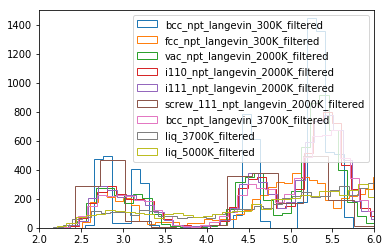

In [74]:
sc = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]
#sc = [2.75]
weights = [1.0 for _ in range(len(trajectories))]
weights[-1] = 10.0

stats_data = {}
target_data = {}

for di, (key, traj) in enumerate(zip(datasets, trajectories)):
    
    print('dataset #', type(traj), len(traj))
    # statistics data
    stats_dict = {'energy':[]}
    for ii, (xyz, box) in enumerate(zip(traj['xyz'], traj['box'])):
        print('conf', ii)
        #if ii > 2:
        #    break
        print('energy', traj['energy'][ii])

        rr, rx = pair_dist_triclinic_o(xyz, box)

        a1, ar, a2, f1, fr, f2 = get_stats_EAM_o(rr, rx, sc)
        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))
        print('x', a1.shape, ar, a1, a2)

        stats_dict['energy'].append(np.array([ar, a2, a1]))
        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        if ii == 10:
            plt.hist(rr.flatten(),100, alpha=1.0,label=datasets[di], histtype='step')
            plt.xlim(2,6)
            plt.ylim(0,1500)
            
    plt.legend()
    stats_data['dset'+str(di)] = stats_dict

In [77]:
[len(stats_dict[d]['energy']) for d in stats_dict.keys()]

TypeError: list indices must be integers or slices, not str

In [75]:
sc = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]
#sc = [2.75]
weights = [1.0 for _ in range(len(trajectories))]
weights[-1] = 10.0

#stats_data = {}
target_data = {}

for di, (traj, weight) in enumerate(zip(trajectories, weights)):
    
    print('dataset #', di)

    # target data
    target_dict = {'type':'trajectory', 'weight':weight}
    target_dict['box'] = traj['box']
    target_dict['xyz'] = traj['xyz']
    target_dict['energy'] = traj['energy']
    target_dict['temp'] = traj['temp']

    # save inverse temperature data (if T=0, set beta=1/300)
    target_dict['beta'] = np.empty_like(target_dict['temp'])
    for i, temp in enumerate(target_dict['temp']):
        if temp == 0.0:
            target_dict['beta'][i] = 1.0/300.0
        else:
            target_dict['beta'][i] = 1.0/temp
            
    target_data['dset'+str(di)] = target_dict

#    # statistics data
#    stats_dict = {'energy':[]}
#    for ii, (xyz, box) in enumerate(zip(traj['xyz'], traj['box'])):
#        print('conf', ii)
        
#        rr, rx = pair_dist_triclinic(xyz, box)

#        a1, ar, a2, f1, fr, f2 = get_stats_EAM(rr, rx, sc)
        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))

#        stats_dict['energy'].append(np.array([ar, a2, a1]))
        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
#        if ii == 10:
#            plt.hist(rr.flatten(),100, alpha=1.0,label=datasets[di], histtype='step')
#            plt.xlim(2,6)
#            plt.ylim(0,1500)
#            
#    plt.legend()
#    stats_data['dset'+str(di)] = stats_dict

dataset # 0
dataset # 1
dataset # 2
dataset # 3
dataset # 4
dataset # 5
dataset # 6
dataset # 7
dataset # 8


In [76]:
# pickle stats and target data to be used for optimization
with open('../data/working/target_filteredx.pickle', 'wb') as fo:
    pickle.dump(target_data, fo)

with open('../data/working/stats_filteredx.pickle', 'wb') as fo:
    pickle.dump(stats_data, fo)

Make combined reference datasets